In [1]:
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import matplotlib.image as mpimg

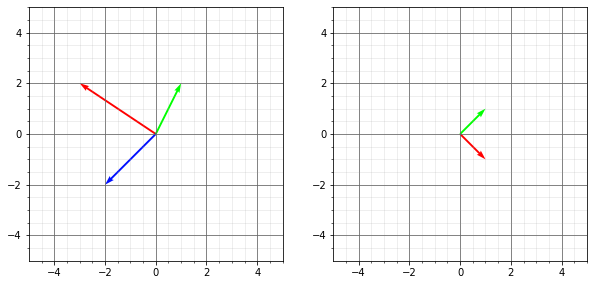

In [2]:
def vplot2D(ax, v, colours, xlim=[-5,5], ylim=[-5,5]):
    # append two columns of zeros to the left (represents origin)
    vplot = np.vstack((np.zeros((2,v.shape[1])), v))
    ax.quiver(vplot[0,:], vplot[1,:], vplot[2,:], vplot[3,:], angles='xy', scale_units='xy', scale=1, color=colours)
    
    # Set the limits so arrows are not out of view
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    # Show the major grid lines with dark grey lines
    ax.grid(b=True, which='major', color='#666666', linestyle='-')

    # Show the minor grid lines with very faint and almost transparent grey lines
    ax.minorticks_on()
    ax.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    ax.set_aspect(1)

# Testing the plotting function
# Set 2x1 figure    
fig, ax = plt.subplots(1,2, figsize=(10,10))

v1 = np.array([[-3, 1, -2],
               [2, 2, -2]])
v2 = np.array([[1, 1], 
               [-1, 1]])
cols = ['#FF0000', '#00FF00', "#000FFF"]

vplot2D(ax[0], v1, colours=cols)
vplot2D(ax[1], v2, colours=cols)

## Singular Value Decomposition (SVD) is $A = U \Sigma V^{*}$ where U and V* are unitary (i.e. conjugate transpose equals its inverse), and $\Sigma$ is a diagonal matrix of singular values (i.e. eigenvalues square rooted($\Sigma = \sqrt{λ}$))

In [3]:
A = np.array([[1, 3], [5, 4]])
print(A, '\n')
print(A@A.T, '\n')
print(A.T@A)

[[1 3]
 [5 4]] 

[[10 17]
 [17 41]] 

[[26 23]
 [23 25]]


In [4]:
eig_val, U = np.linalg.eig(A@A.T)

# Sort eigenval & eigenvec in from largest to smallest
idx = eig_val.argsort()[::-1]   
eig_val = eig_val[idx]
U = U[:,idx]

print(eig_val, '\n\n',U)

[48.50543414  2.49456586] 

 [[-0.40388497 -0.91480978]
 [-0.91480978  0.40388497]]


In [5]:
Sigma = np.diag(np.sqrt(np.abs(eig_val)))
# Sigma = np.diag(np.sqrt(eig_val.astype(np.complex)))
Sigma

array([[6.96458428, 0.        ],
       [0.        , 1.57941947]])

In [6]:
eig_val, V = np.linalg.eig(A.T@A)

# Sort eigenval & eigenvec in from largest to smallest
idx = eig_val.argsort()[::-1]   
eig_val = eig_val[idx]
V = V[:,idx]

# We reverse the signs in V because eigenvalues are calculated independently
# This change doesn't always guarantee that U@Sigma@V.T will give A
V = -1*V

print(eig_val, '\n\n', V)

[48.50543414  2.49456586] 

 [[-0.7147496   0.69938044]
 [-0.69938044 -0.7147496 ]]


In [7]:
U@Sigma@V.T

array([[1., 3.],
       [5., 4.]])

In [8]:
# Instead of manually computing the SVD, we can utilize numpy's function
U, S, Vh = np.linalg.svd(A)
S = np.diag(S)
print(U, '\n')
print(S, '\n')
print(Vh, '\n')
U@S@Vh

[[-0.40388497 -0.91480978]
 [-0.91480978  0.40388497]] 

[[6.96458428 0.        ]
 [0.         1.57941947]] 

[[-0.7147496  -0.69938044]
 [ 0.69938044 -0.7147496 ]] 



array([[1., 3.],
       [5., 4.]])

## Application: Image Compression

(1549, 1216)


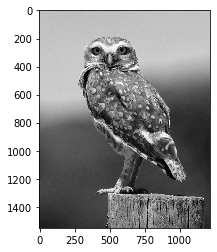

In [9]:
import cv2
import requests
import matplotlib.image as mpimg
    
url = r'https://upload.wikimedia.org/wikipedia/commons/1/14/Athene_cuniculariaa.jpg'
resp = requests.get(url, stream=True).raw
image = np.asarray(bytearray(resp.read()), dtype="uint8")
image = cv2.imdecode(image, cv2.IMREAD_GRAYSCALE)
print(image.shape)
imgplot = plt.imshow(image, cmap='gray')

(1549, 1549)
(1549, 1216)
(1216, 1216)


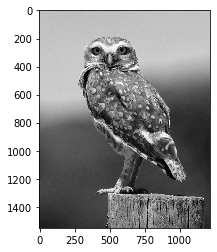

In [20]:
U, D, V = np.linalg.svd(image) # Notation: We will use D instead of Sigma for simplicity

# Here we convert convert D to a mxn matrix with entries along the diagonal 
D_diag = np.diag(D)
D_full = np.zeros((image.shape[0], image.shape[1]))
D_full[:D_diag.shape[0], :D_diag.shape[1]] = D_diag

# If the image is mxn
print(U.shape) # Then this is mxm
print(D_full.shape) # Then this is mxn
print(V.shape) # Then this is nxn

# We should get the original image with full resolution
plt.imshow(U@D_full@V, cmap='gray')

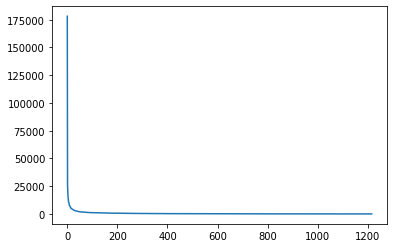

In [11]:
# Plot the different singular values in order from largest to smallest
# This shows that the largest singular values contribute to the image a lot more than the smaller ones
plt.plot(D)

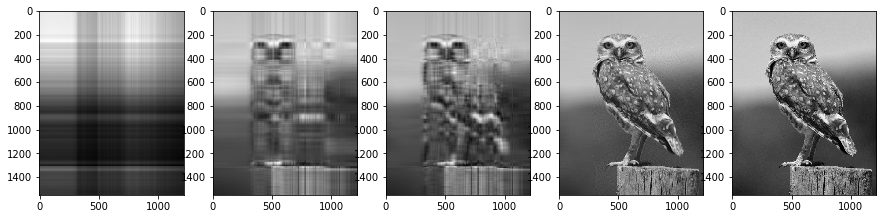

In [12]:
def compress_image(U, D, V, n):
    U_new = U[:, :n]
    D_new = np.diag(D[:n])
    V_new = V[:n, :]
#     print(U_new.shape)
#     print(D_new.shape)
#     print(V_new.shape)
    return U_new@D_new@V_new

# By varing the n value we change the rank of compression.
n_values = [1, 5, 10, 100, 1216]
n_values_size = len(n_values)
fig, ax = plt.subplots(1, n_values_size, figsize=(15, 15))

for i in range(n_values_size):
    new_image = compress_image(U, D, V, n_values[i])
    ax[i].imshow(new_image, cmap='gray')

## Application: Moore-Penrose Pseudoinverse

$$Ax=b$$ 
$$A^{-1}Ax=A^{-1}b$$ $$x=A^{-1}b$$
What if A is not mxm?
We can still find a matrix $A^{+}$ (the moore-penrose pseudoinverse) such that it evaluates to approximately the identity matrix when multiplied by itself.

Consider finding x when A is mxn matrix (i.e. not-invertible). $A^{T}A$ gives an nxn matrix.
$$Ax = b$$
$$A^{T}Ax = A^{T}b $$
$$(A^{T}A)^{-1}(A^{T}A)x = (A^{T}A)^{-1}A^{T}b $$
$$ x = (A^{T}A)^{-1}A^{T}b$$

We shall call the pseudoinverse $A^{+} = (A^{T}A)^{-1}A^{T}$

In [43]:
A = image
A_plus = np.linalg.inv(A.T@A)@A.T
A_plus.shape

(1216, 1549)


The pseudoinverse can be derived from the SVD via the relation $A^{+} = VD^{+}U^{*}$ where U is left singular vectors, $D^{+}$ is diagonal matrix of singular values which is reciprocal of non zero values, V is right eingular vectors. 